<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/GLCM_cancer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History 

from random import randint
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.pyplot as pp

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from tensorflow.keras import datasets, layers, models
from xgboost import XGBClassifier
%matplotlib inline

# Making the dataset:

In [3]:
import os
from tqdm import tqdm
from skimage.io import imread

# read all the images first
x_train = []
for i in range(1, 4): # changed to 3 classes
    base_dir = f'/content/drive/MyDrive/cancer_dataG/stage_{i}_png/'
    files = os.listdir(base_dir)
    for file in tqdm(files):
        img = imread(base_dir+file)
        x_train.append(img)
X_train = np.array(x_train)
X_train.shape

100%|██████████| 250/250 [00:03<00:00, 74.22it/s] 


(750, 512, 512)

In [4]:
NUM = 250
CLASSES = 3 #4
y_train = []
class_label = 0
for i in range(NUM * CLASSES):
    if i > 0 and i %  NUM == 0:
        class_label += 1
    y_train.append(class_label)
Y_train = np.array(y_train)

In [5]:
# Shuffle training data
shuffler = np.random.permutation(NUM * CLASSES)

X_train = np.array(X_train)

x_train = X_train[shuffler].astype(np.uint8)
y_train = Y_train[shuffler]

2


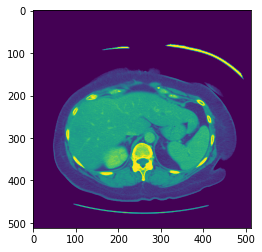

In [6]:
print(y_train[101])
plt.imshow(x_train[101])

# GLCM Feature extraction:

In [7]:
from skimage.feature import greycomatrix, greycoprops

x_features = [] # list of all features of all images

#loop over images
for img in tqdm(x_train):
    features = [] # list of features for each image
    # loop over neighbor size for GLCM
    for size in [1, 3, 5]:
        # loop over angles for GLCM
        for angle in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
            #A statistical method of examining texture that considers the spatial relationship of pixels
            GLCM = greycomatrix(img, [size], [angle]) # apply GLCM on image
            # extracting different attributes out of the GLCM
            # closeness of the distribution of elements in the GLCM to the GLCM diagonal.
            features.extend(greycoprops(GLCM, 'energy')[0])
            # realtionship between the features
            features.extend(greycoprops(GLCM, 'correlation')[0])
            #  measure of distance between pairs of objects (pixels) in the region of interest.
            features.extend(greycoprops(GLCM, 'dissimilarity')[0])
            # the homogeneity of image textures and scaled the local changes of image texture
            features.extend(greycoprops(GLCM, 'homogeneity')[0])
            # a measure of the intensity contrast between a pixel and its neighbor over the whole image
            features.extend(greycoprops(GLCM, 'contrast')[0])
    x_features.append(features)

100%|██████████| 750/750 [01:45<00:00,  7.09it/s]


In [8]:
x_features = np.array(x_features)
# (num_images, num_size * num_angles * num_features)
x_features.shape

(750, 60)

# Splitting:

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_features, y_train,
                                                    stratify=y_train, 
                                                    test_size=0.2)
results = {}

In [10]:
print(x_train.shape)
print(x_test.shape)

(600, 60)
(150, 60)


# Applying models:

## Light GBM:

In [11]:
# fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, 
#!pip install lightgbm
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train)

# https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves':100,
              'max_depth':10,
              'num_class':3}  #no.of unique values in the target class not inclusive of the end value


lgb_model = lgb.train(lgbm_params, d_train, 100)

# Predict the response for test dataset
#img -> 1 => argmax([ 0.12, 0.82, 0.06]) => 1
y_pred = lgb_model.predict(x_test)
# get the index of max value in each row
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred)
results['lgb'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [12]:
def showconfusionmatrix(cm):
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


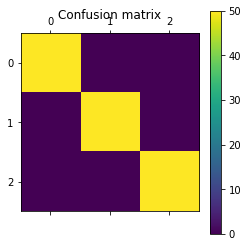

In [13]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## SVM

In [14]:
# Train the Linear SVM
from sklearn.svm import LinearSVC

clf = LinearSVC(max_iter=10000)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['SVM'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


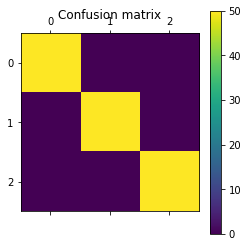

In [15]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Random Forest:

In [16]:
# creating a random forest
clf =  RandomForestClassifier(n_estimators = 100, random_state=30)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['random_forest'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


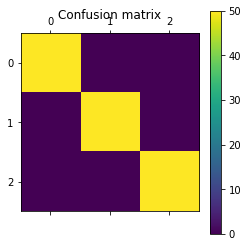

In [17]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Decision Tree:

In [18]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['decision_tree'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9933333333333333

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



[[49  1  0]
 [ 0 50  0]
 [ 0  0 50]]


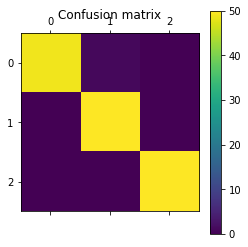

In [19]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

[Text(0.4230769230769231, 0.9285714285714286, 'X[2] <= 3.327\ngini = 0.667\nsamples = 600\nvalue = [200, 200, 200]'),
 Text(0.19230769230769232, 0.7857142857142857, 'X[7] <= 5.243\ngini = 0.287\nsamples = 181\nvalue = [150, 29, 2]'),
 Text(0.07692307692307693, 0.6428571428571429, 'X[54] <= 830.714\ngini = 0.083\nsamples = 139\nvalue = [133, 6, 0]'),
 Text(0.038461538461538464, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [0, 4, 0]'),
 Text(0.11538461538461539, 0.5, 'X[2] <= 3.128\ngini = 0.029\nsamples = 135\nvalue = [133, 2, 0]'),
 Text(0.07692307692307693, 0.35714285714285715, 'X[7] <= 5.147\ngini = 0.015\nsamples = 134\nvalue = [133, 1, 0]'),
 Text(0.038461538461538464, 0.21428571428571427, 'gini = 0.0\nsamples = 125\nvalue = [125, 0, 0]'),
 Text(0.11538461538461539, 0.21428571428571427, 'X[54] <= 1111.022\ngini = 0.198\nsamples = 9\nvalue = [8, 1, 0]'),
 Text(0.07692307692307693, 0.07142857142857142, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.15384615384615385, 0.071428571428

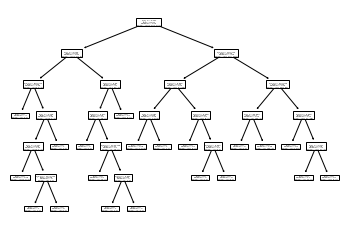

In [20]:
# plot tree
from sklearn import tree

tree.plot_tree(clf)

## AdaBoost Classifier:

In [21]:
# Create Adaboostclassifier
clf = AdaBoostClassifier(n_estimators=42)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['ada_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.7333333333333333

              precision    recall  f1-score   support

           0       0.93      0.56      0.70        50
           1       0.59      0.66      0.62        50
           2       0.77      0.98      0.86        50

    accuracy                           0.73       150
   macro avg       0.76      0.73      0.73       150
weighted avg       0.76      0.73      0.73       150



[[28 22  0]
 [ 2 33 15]
 [ 0  1 49]]


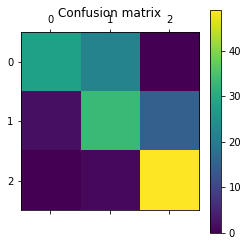

In [22]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## XG Boost Classifier:

In [23]:
# Create XG boost classifer object
clf = XGBClassifier()

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['xg_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9933333333333333

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        50
           2       1.00      1.00      1.00        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



[[50  0  0]
 [ 1 49  0]
 [ 0  0 50]]


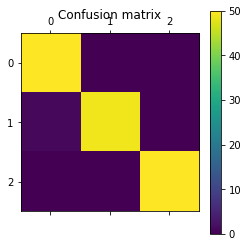

In [24]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Gaussian Naive Bayes:

In [25]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes Classifier
clf = GaussianNB()

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['gauss_NB'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.68

              precision    recall  f1-score   support

           0       0.64      0.86      0.74        50
           1       0.82      0.18      0.30        50
           2       0.69      1.00      0.82        50

    accuracy                           0.68       150
   macro avg       0.72      0.68      0.62       150
weighted avg       0.72      0.68      0.62       150



In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[[43  2  5]
 [24  9 17]
 [ 0  0 50]]


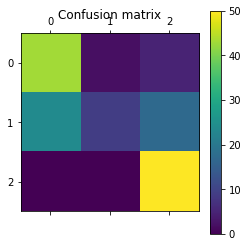

In [27]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Logistic Regression:

In [28]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
clf = LogisticRegression(solver='liblinear')

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['log_regression'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


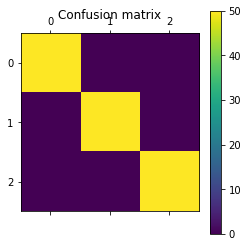

In [29]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

# Plotting the results:

<BarContainer object of 8 artists>

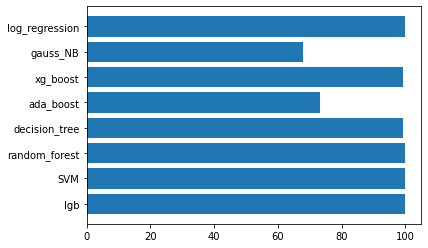

In [30]:
plt.barh(list(results.keys()), results.values())

In [31]:
results

{'SVM': 100.0,
 'ada_boost': 73.33,
 'decision_tree': 99.33,
 'gauss_NB': 68.0,
 'lgb': 100.0,
 'log_regression': 100.0,
 'random_forest': 100.0,
 'xg_boost': 99.33}